<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 1024

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Вроде как, в теории мы должны учиться быстрее. У нас есть задача минимизации на простраснтве признаков с некоторой целевой переменной (например, средний квадрат отклонения). Мы хотим по этому простраснтву двигаться с помощью градиентного спуска. Перебор по одному объекту может приводить к странному движению в пространстве признаков. Когда мы берём большой батч, мы будем уверенными шагами в среднем двигаться к правильному минимуму целевой переменной. Поэтому кажется, что учимся мы так быстрее)

Посмотрим на какую-нибудь картинку:

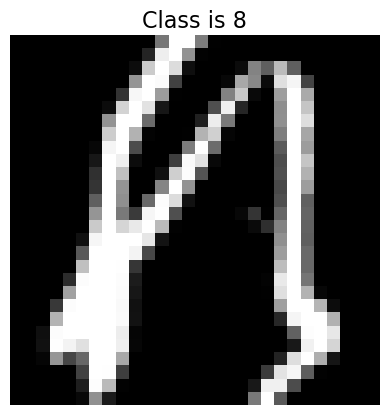

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





Сделаем по-простому. Будем бежать по данным, проверяя какой у них класс, когда будем встречать класс, которого ещё не было, докидываем индекс этого объекта в вывод и продолжаем, рано или поздно мы найдём все 10 классов. Выведем вывод)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
to show: [index, class]  [[0, 8], [1, 7], [2, 0], [3, 1], [4, 4], [5, 2], [10, 5], [15, 6], [18, 9], [21, 3]]


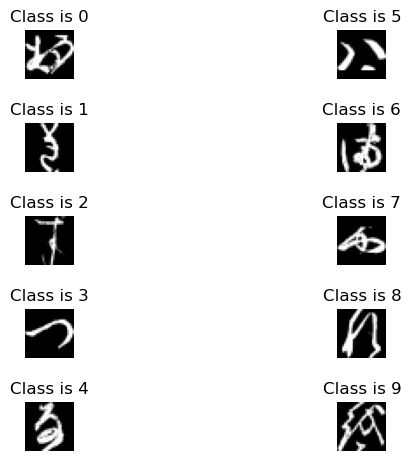

In [5]:
idx_to_show = []
classes_to_add = list(range(10))
print(classes_to_add)
for i, obj in enumerate(trainset):
    if obj[1] in classes_to_add:
        idx_to_show.append([i, obj[1]])
        classes_to_add.pop(classes_to_add.index(obj[1]))
print("to show: [index, class] ", idx_to_show)
idx_to_show = sorted(idx_to_show, key=lambda x: (x[1]))

rows =5
cols =2
f, axarr = plt.subplots(rows,cols)
f.tight_layout()
for i in range(0,cols):
    for j in range(0,rows):
        axarr[j,i].imshow(trainset[idx_to_show[i*5+j][0]][0].view(28, 28).numpy(), cmap="gray")
        axarr[j,i].axis("off")
        axarr[j,i].title.set_text(f"Class is {trainset[idx_to_show[i*5+j][0]][1]}")

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [81]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        input_size = 28*28
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        logits = x
        
        return logits
    
class FCNet_ReluAtEnd(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        input_size = 28*28
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        logits = x
        
        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

(28 * 28 * 256 + 256 * 128 + 128 * 10) + (256 + 128 + 10) = 235146 //
(веса) + (смещения) = ответ

Подумаем про активацию после последнего слоя. CrossEntropyLoss принимает на вход ненормированную штуку: "The input is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general).". То есть в принципе ему туда можно скормить ненормированный выход, применение софтмакса или чего-то такого не является необходимым. Также было протестировано, что если поставить на выход, например, F.relu(x), то результат станет значительно хуже. 

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [7]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [8]:
# Создадим объект модели
fc_net = FCNet()
fc_net_ReluAtEnd = FCNet_ReluAtEnd()
print(fc_net)
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
optimizer_ReluAtEnd = torch.optim.Adam(fc_net_ReluAtEnd.parameters(), lr=3e-4)

FCNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [9]:
n_epochs = 10
loss_history = []
loss_history_ReluAtEnd = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    
    
## Chech with Relu at End
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer_ReluAtEnd.zero_grad()
        outputs = fc_net_ReluAtEnd(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer_ReluAtEnd.step()
        epoch_loss += loss.item()
        
    loss_history_ReluAtEnd.append(epoch_loss/len(trainloader))

    print(f"With Relu: Epoch={epoch+1} loss={loss_history_ReluAtEnd[epoch]:.4f}")


Epoch=1 loss=1.5886
Epoch=2 loss=0.6979
Epoch=3 loss=0.5286
Epoch=4 loss=0.4543
Epoch=5 loss=0.4029
Epoch=6 loss=0.3657
Epoch=7 loss=0.3337
Epoch=8 loss=0.3096
Epoch=9 loss=0.2855
Epoch=10 loss=0.2659
With Relu: Epoch=1 loss=1.7167
With Relu: Epoch=2 loss=0.8178
With Relu: Epoch=3 loss=0.6355
With Relu: Epoch=4 loss=0.5454
With Relu: Epoch=5 loss=0.4852
With Relu: Epoch=6 loss=0.4390
With Relu: Epoch=7 loss=0.4041
With Relu: Epoch=8 loss=0.3755
With Relu: Epoch=9 loss=0.3519
With Relu: Epoch=10 loss=0.3278


In [10]:
Acc_withoutRelu = get_accuracy(fc_net, testloader)
Acc_withRelu = get_accuracy(fc_net_ReluAtEnd, testloader)
print("Acc without relu at the end", Acc_withoutRelu)
print("Acc with relu at the end", Acc_withRelu)

Acc without relu at the end 0.8183
Acc with relu at the end 0.8053


Неприменение нелинейности Relu на последнем слое качественно улучшает результат. Наверное, можно попробовать объяснить такой эффект соображениями переведения в 0 всех отрацительных значений на выходе из нейросети. Всё, что имело бы околонулевые вероятности после softmax, поднимает вероятности до каких-то средних значений. И там, где сеть не имеет выраженного кандидата на ответ она ошибается... 

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

Пусть N - число картинок, n - число пикселдей на картинке. Тогда:
$x_{avg} = \frac{1}{N * n} \sum_1^{N * n} x_i = \frac{1}{N} \sum_1^{N} (\frac{1}{n} \sum_1^{n} x_i)$ Среднее посчитаем как среднее средней интенсивности на картинке. Примерно также расправляемся со среднеквадратичным отклонением:
$x_{std}^2 = \frac{1}{N * n} \sum_1^{N * n} (x_i - x_{avg})^{2} = = \frac{1}{N} \sum_1^{N} (\frac{1}{n} \sum_1^{n} (x_i - x_{avg})^{2})$  


In [11]:
mean=0
trainset_avg = np.asarray([obj[0].mean() for obj in trainset])
mean = trainset_avg.mean()
print(mean)

0.19176215


In [12]:
import math
std = 0
# заготавливаем массив из квадратов отклоениня по пикселям
trainset_std = np.asarray([((obj[0]-mean)**2).mean() for obj in trainset])
# переводим его в средний квадраит отклонения по картинке
trainset_std = np.asarray([obj.mean() for obj in trainset_std])
# усредняем по всем картинкам
std = math.sqrt(trainset_std.mean())
print(std)

0.3483428390284319


In [13]:
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

0.19176215 0.3483428390284319


In [55]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        outputs = fc_net(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=1.2073
Epoch=2 loss=0.4949
Epoch=3 loss=0.3721
Epoch=4 loss=0.3059
Epoch=5 loss=0.2626
Epoch=6 loss=0.2301
Epoch=7 loss=0.2028
Epoch=8 loss=0.1789
Epoch=9 loss=0.1603
Epoch=10 loss=0.1426


In [16]:
get_accuracy(fc_net, testloader)

0.8699

Как изменилась `accuracy` после нормализации?

После нормализации accuracy немного выросла)

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

Ну, тут дальше много некрасивого кода) Но оно всё работает) Возьмём модели трёх классов и все их обучим)

In [17]:
class FCNetSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 28*28
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        
        x = x.view(-1, 28*28)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        logits = x
        
        return logits

class FCNetGelu(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 28*28
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        
        x = x.view(-1, 28*28)
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = self.fc3(x)
        logits = x
        
        return logits
    
class FCNetTanh(nn.Module):
    def __init__(self):
        super().__init__()
        input_size = 28*28
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        
        x = x.view(-1, 28*28)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        logits = x
        
        return logits

In [18]:
fc_net_sigmoid = FCNetSigmoid()
fc_net_gelu=FCNetGelu()
fc_net_tanh=FCNetTanh()

optimizer_sigmoid = torch.optim.Adam(fc_net_sigmoid.parameters(), lr=3e-4)
optimizer_gelu = torch.optim.Adam(fc_net_gelu.parameters(), lr=3e-4)
optimizer_tanh = torch.optim.Adam(fc_net_tanh.parameters(), lr=3e-4)

In [19]:
n_epochs = 10
loss_history_sigmoid = []
loss_history_gelu = []
loss_history_tanh = []


for epoch in range(n_epochs):
    epoch_loss_sigmoid = 0
    epoch_loss_gelu = 0
    epoch_loss_tanh = 0
    
    for images, labels in trainloader:
        
        optimizer_sigmoid.zero_grad()
        optimizer_gelu.zero_grad()
        optimizer_tanh.zero_grad()
        
        outputs_sigmoid = fc_net_sigmoid(images)
        outputs_gelu = fc_net_gelu(images)
        outputs_tanh = fc_net_tanh(images)
        
        loss_sigmoid = loss_function(outputs_sigmoid, labels)
        loss_gelu = loss_function(outputs_gelu, labels)
        loss_tanh = loss_function(outputs_tanh, labels)
        
        loss_sigmoid.backward()
        loss_gelu.backward()
        loss_tanh.backward()
        
        optimizer_sigmoid.step()
        optimizer_gelu.step()
        optimizer_tanh.step()
        
        epoch_loss_sigmoid += loss_sigmoid.item()
        epoch_loss_gelu += loss_gelu.item()
        epoch_loss_tanh += loss_tanh.item()

    loss_history_sigmoid.append(epoch_loss_sigmoid/len(trainloader))
    loss_history_gelu.append(epoch_loss_gelu/len(trainloader))
    loss_history_tanh.append(epoch_loss_tanh/len(trainloader))

    print(f"Epoch ={epoch+1} loss sigmoid={loss_history_sigmoid[epoch]:.4f}")
    print(f"Epoch={epoch+1} loss gelu={loss_history_gelu[epoch]:.4f}")
    print(f"Epoch={epoch+1} loss tanh={loss_history_tanh[epoch]:.4f}")


Epoch =1 loss sigmoid=2.1058
Epoch=1 loss gelu=1.1954
Epoch=1 loss tanh=1.2197
Epoch =2 loss sigmoid=1.5823
Epoch=2 loss gelu=0.4681
Epoch=2 loss tanh=0.6449
Epoch =3 loss sigmoid=1.1567
Epoch=3 loss gelu=0.3469
Epoch=3 loss tanh=0.5056
Epoch =4 loss sigmoid=0.8970
Epoch=4 loss gelu=0.2844
Epoch=4 loss tanh=0.4131
Epoch =5 loss sigmoid=0.7438
Epoch=5 loss gelu=0.2406
Epoch=5 loss tanh=0.3414
Epoch =6 loss sigmoid=0.6465
Epoch=6 loss gelu=0.2082
Epoch=6 loss tanh=0.2869
Epoch =7 loss sigmoid=0.5782
Epoch=7 loss gelu=0.1806
Epoch=7 loss tanh=0.2423
Epoch =8 loss sigmoid=0.5252
Epoch=8 loss gelu=0.1592
Epoch=8 loss tanh=0.2068
Epoch =9 loss sigmoid=0.4829
Epoch=9 loss gelu=0.1404
Epoch=9 loss tanh=0.1777
Epoch =10 loss sigmoid=0.4467
Epoch=10 loss gelu=0.1246
Epoch=10 loss tanh=0.1524


In [20]:
sigmoid_acc = get_accuracy(fc_net_sigmoid, testloader)
gelu_acc = get_accuracy(fc_net_gelu, testloader)
tanh_acc = get_accuracy(fc_net_tanh, testloader)

In [21]:
print("sigmoid accuracy = ", sigmoid_acc)
print("sigmoid accuracy = ", gelu_acc)
print("sigmoid accuracy = ", tanh_acc)

sigmoid accuracy =  0.7545
sigmoid accuracy =  0.8754
sigmoid accuracy =  0.8701


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Наибольшая точность достигнута при активационной функции gelu) Выглядит она довольно страшно, а выигрыш относительно "простой" Relu незначительный... Сигмоида оказалась худшей из представленного списка...Ну и скорость обучения визуально лучше у gelu (производная не строилась :))

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [25]:
fc_net_Adam = FCNetGelu()
fc_net_RMSprop = FCNetGelu()
fc_net_Adagrad = FCNetGelu()

optimizer_gelu_Adam = torch.optim.Adam(fc_net_Adam.parameters(), lr=3e-4)
optimizer_gelu_RMSprop = torch.optim.RMSprop(fc_net_RMSprop.parameters(), lr=3e-4)
optimizer_gelu_Adagrad = torch.optim.Adagrad(fc_net_Adagrad.parameters(), lr=3e-4)

n_epochs = 10
loss_history_Adam = []
loss_history_RMSprop = []
loss_history_Adagrad = []

for epoch in range(n_epochs):
    epoch_loss_Adam = 0
    epoch_loss_RMSprop = 0
    epoch_loss_Adagrad = 0
    
    for images, labels in trainloader:
        
        optimizer_gelu_Adam.zero_grad()
        optimizer_gelu_RMSprop.zero_grad()
        optimizer_gelu_Adagrad.zero_grad()
        
        outputs_gelu_Adam = fc_net_Adam(images)
        outputs_gelu_RMSprop = fc_net_RMSprop(images)
        outputs_gelu_Adagrad = fc_net_Adagrad(images)
        
        loss_gelu_Adam = loss_function(outputs_gelu_Adam, labels)
        loss_gelu_RMSprop = loss_function(outputs_gelu_RMSprop, labels)
        loss_gelu_Adagrad = loss_function(outputs_gelu_Adagrad, labels)
        
        loss_gelu_Adam.backward()
        loss_gelu_RMSprop.backward()
        loss_gelu_Adagrad.backward()
        
        optimizer_gelu_Adam.step()
        optimizer_gelu_RMSprop.step()
        optimizer_gelu_Adagrad.step()
        
        epoch_loss_Adam += loss_gelu_Adam.item()
        epoch_loss_RMSprop += loss_gelu_RMSprop.item()
        epoch_loss_Adagrad += loss_gelu_Adagrad.item()
        
    loss_history_Adam.append(epoch_loss_Adam/len(trainloader))
    loss_history_RMSprop.append(epoch_loss_RMSprop/len(trainloader))
    loss_history_Adagrad.append(epoch_loss_Adagrad/len(trainloader))

    print(f"Epoch ={epoch+1} loss Adam={loss_history_Adam[epoch]:.4f}")
    print(f"Epoch={epoch+1} loss RMSprop={loss_history_RMSprop[epoch]:.4f}")
    print(f"Epoch={epoch+1} loss Adagrad={loss_history_Adagrad[epoch]:.4f}")

Epoch =1 loss Adam=1.1974
Epoch=1 loss RMSprop=0.6367
Epoch=1 loss Adagrad=1.8154
Epoch =2 loss Adam=0.4847
Epoch=2 loss RMSprop=0.3346
Epoch=2 loss Adagrad=1.2365
Epoch =3 loss Adam=0.3611
Epoch=3 loss RMSprop=0.2654
Epoch=3 loss Adagrad=0.9890
Epoch =4 loss Adam=0.2936
Epoch=4 loss RMSprop=0.2216
Epoch=4 loss Adagrad=0.8587
Epoch =5 loss Adam=0.2495
Epoch=5 loss RMSprop=0.1886
Epoch=5 loss Adagrad=0.7771
Epoch =6 loss Adam=0.2152
Epoch=6 loss RMSprop=0.1642
Epoch=6 loss Adagrad=0.7219
Epoch =7 loss Adam=0.1871
Epoch=7 loss RMSprop=0.1439
Epoch=7 loss Adagrad=0.6806
Epoch =8 loss Adam=0.1638
Epoch=8 loss RMSprop=0.1267
Epoch=8 loss Adagrad=0.6488
Epoch =9 loss Adam=0.1447
Epoch=9 loss RMSprop=0.1125
Epoch=9 loss Adagrad=0.6229
Epoch =10 loss Adam=0.1291
Epoch=10 loss RMSprop=0.0989
Epoch=10 loss Adagrad=0.6016


In [28]:
Adam_acc = get_accuracy(fc_net_Adam, testloader)
RMSprop_acc = get_accuracy(fc_net_RMSprop, testloader)
Adagrad_acc = get_accuracy(fc_net_Adagrad, testloader)
print("Adam accuracy = ", Adam_acc)
print("RMSprop accuracy = ", RMSprop_acc)
print("Adagrad accuracy = ", Adagrad_acc)

Adam accuracy =  0.8803
RMSprop accuracy =  0.883
Adagrad accuracy =  0.684


Adam и RMSprop имеют практически одинаковый перфоманс.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [124]:
def CustomReluFunction(x):
    x[x < 0] = 0
    return x

In [125]:
a = torch.randn(1, 3)
reludef = F.relu(a)
relucustom = CustomReluFunction(a)
print(reludef, relucustom)

tensor([[1.1966, 0.0000, 1.5110]]) tensor([[1.1966, 0.0000, 1.5110]])


На уровне операций с тензором ничего не поменялось.

In [129]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()
        input_size = 28*28
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)

        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = CustomReluFunction(x)
        x = self.fc2(x)
        x = CustomReluFunction(x)
        x = self.fc3(x)
        logits = x
        
        return logits

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [130]:
fc_net_custom = CustomReLU()
fc_net = FCNet()

loss_function = nn.CrossEntropyLoss()
optimizer_custom = torch.optim.Adam(fc_net_custom.parameters(), lr=3e-4)
optimizer_def = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

n_epochs = 10
loss_history_custom = []
loss_history_def = []

for epoch in range(n_epochs):
    epoch_loss_custom = 0
    epoch_loss_def = 0
    
    for images, labels in trainloader:
        optimizer_custom.zero_grad()
        optimizer_def.zero_grad()
        
        outputs_custom = fc_net_custom(images)
        outputs_def = fc_net(images)
        
        loss_custom = loss_function(outputs_custom, labels)
        loss_def = loss_function(outputs_def, labels)
        
        loss_custom.backward()
        loss_def.backward()
        
        optimizer_custom.step()
        optimizer_def.step()
        
        epoch_loss_custom += loss_custom.item()
        epoch_loss_def+= loss_def.item()
        
    loss_history_custom.append(epoch_loss_custom/len(trainloader))
    loss_history_def.append(epoch_loss_def/len(trainloader))

    print(f"Epoch={epoch+1} custom loss={loss_history_custom[epoch]:.4f}")
    print(f"default loss={loss_history_def[epoch]:.4f}")

Epoch=1 custom loss=1.2053
default loss=1.2278
Epoch=2 custom loss=0.4929
default loss=0.4892
Epoch=3 custom loss=0.3706
default loss=0.3690
Epoch=4 custom loss=0.3047
default loss=0.3055
Epoch=5 custom loss=0.2608
default loss=0.2626
Epoch=6 custom loss=0.2281
default loss=0.2305
Epoch=7 custom loss=0.2002
default loss=0.2024
Epoch=8 custom loss=0.1779
default loss=0.1803
Epoch=9 custom loss=0.1578
default loss=0.1603
Epoch=10 custom loss=0.1407
default loss=0.1426


Различия скорее всего обучловлены различным объявлением начальных весов.

In [131]:
print(get_accuracy(fc_net, testloader))
print(get_accuracy(fc_net_custom, testloader))

0.8714
0.8703


### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.